In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


In [282]:
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')
sample_submission = pd.read_csv('./data/SampleSubmission.csv')

## Exploratory Data Analysis

In [283]:
train.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [252]:
test.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [253]:
sample_submission.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [254]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


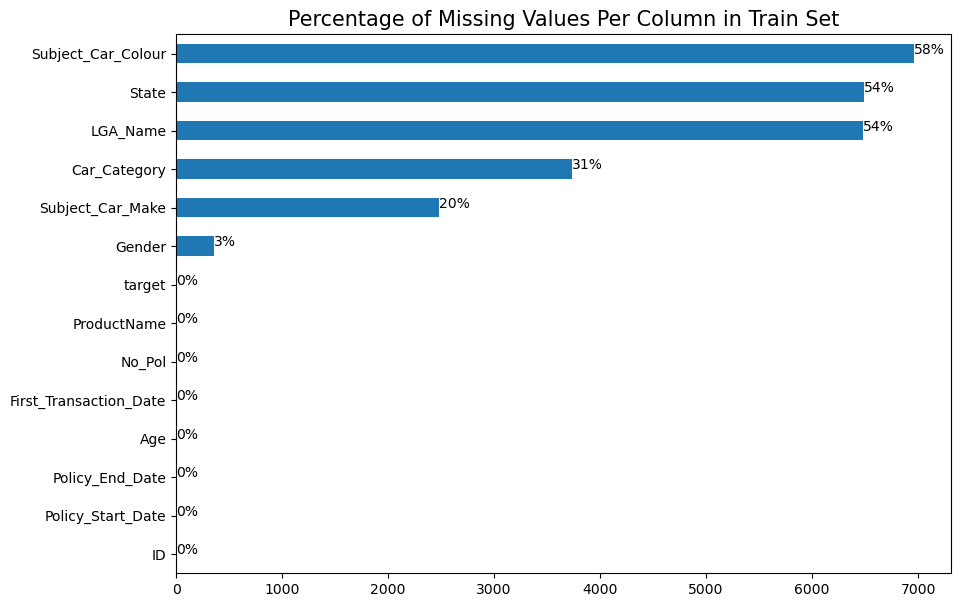

In [255]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [256]:
train[train['Age'] < 18]. count()

ID                        556
Policy_Start_Date         556
Policy_End_Date           556
Gender                    534
Age                       556
First_Transaction_Date    556
No_Pol                    556
Car_Category              356
Subject_Car_Colour        169
Subject_Car_Make          429
LGA_Name                  225
State                     225
ProductName               556
target                    556
dtype: int64

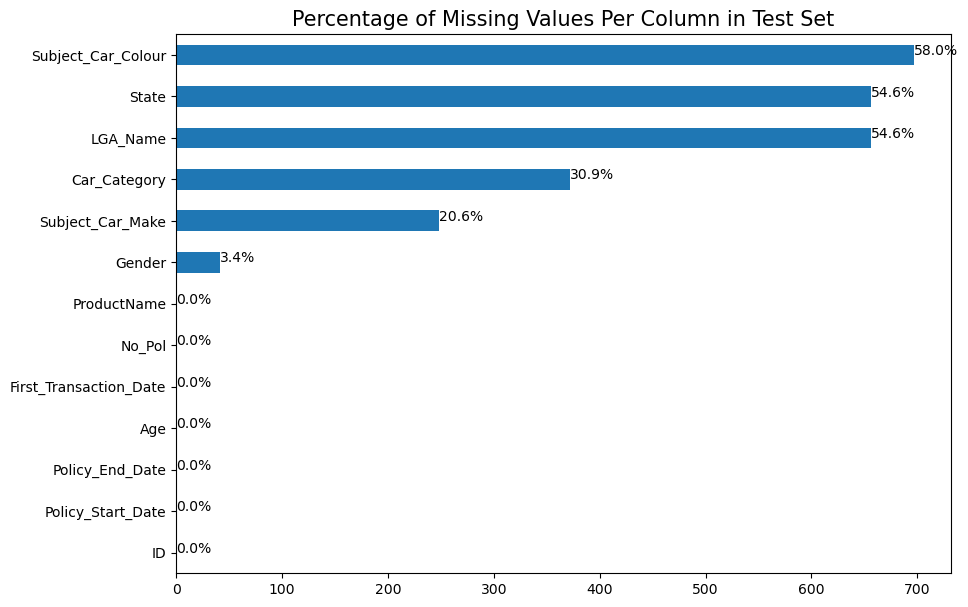

In [257]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Data Preprocessing

In [258]:
train['Policy_Start_Date'] = pd.to_datetime(train['Policy_Start_Date'])
train['Policy_End_Date'] = pd.to_datetime(train['Policy_End_Date'])
train['First_Transaction_Date'] = pd.to_datetime(train['First_Transaction_Date'])

test['Policy_Start_Date'] = pd.to_datetime(test['Policy_Start_Date'])
test['Policy_End_Date'] = pd.to_datetime(test['Policy_End_Date'])
test['First_Transaction_Date'] = pd.to_datetime(test['First_Transaction_Date'])

In [259]:
train['StartYear'] = train['Policy_Start_Date'].dt.year
train['EndYear'] = train['Policy_End_Date'].dt.year
train['FirstYear'] = train['First_Transaction_Date'].dt.year

train['StartMonth'] = train['Policy_Start_Date'].dt.month
train['EndMonth'] = train['Policy_End_Date'].dt.month
train['FirstMonth'] = train['First_Transaction_Date'].dt.month

train['StartDay'] = train['Policy_Start_Date'].dt.day
train['EndDay'] = train['Policy_End_Date'].dt.day
train['FirstDay'] = train['First_Transaction_Date'].dt.day

In [260]:
test['StartYear'] = test['Policy_Start_Date'].dt.year
test['EndYear'] = test['Policy_End_Date'].dt.year
test['FirstYear'] = test['First_Transaction_Date'].dt.year

test['StartMonth'] = test['Policy_Start_Date'].dt.month
test['EndMonth'] = test['Policy_End_Date'].dt.month
test['FirstMonth'] = test['First_Transaction_Date'].dt.month

test['StartDay'] = test['Policy_Start_Date'].dt.day
test['EndDay'] = test['Policy_End_Date'].dt.day
test['FirstDay'] = test['First_Transaction_Date'].dt.day

## Handle Missing Values

In [262]:
def front_fill_data(data, columns):
    for column in columns:
        data[column] = data[column].fillna(method='ffill')
    return data

front_fill_columns = ['Gender','Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']

front_filled_train = front_fill_data(train, front_fill_columns)
front_filled_test = front_fill_data(test, front_fill_columns)


/var/folders/0n/p9ms0b591cg7_09nh12318dr0000gn/T/ipykernel_37352/4060081857.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[column] = data[column].fillna(method='ffill')


In [263]:
train.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,StartYear,EndYear,FirstYear,StartMonth,EndMonth,FirstMonth,StartDay,EndDay,FirstDay
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0,2010,2011,2010,5,5,5,14,13,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1,2010,2011,2010,11,11,11,29,28,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0,2010,2011,2010,3,3,3,21,20,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Red,TOYOTA,...,0,2010,2011,2010,8,8,8,21,20,21
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,Saloon,Red,TOYOTA,...,1,2010,2010,2010,8,12,8,29,31,29


In [264]:
test.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,ProductName,StartYear,EndYear,FirstYear,StartMonth,EndMonth,FirstMonth,StartDay,EndDay,FirstDay
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,...,Car Classic,2010,2011,2010,10,10,10,23,22,23
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,Ford,...,Car Classic,2010,2011,2010,10,10,10,14,13,14
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,...,Car Classic,2010,2011,2010,8,8,8,29,28,29
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,Black,TOYOTA,...,CarSafe,2010,2011,2010,6,6,6,13,12,13
4,ID_02YB37K,2010-07-01,2011-06-30,Female,120,2010-07-01,1,Saloon,Red,Hyundai,...,Car Classic,2010,2011,2010,7,6,7,1,30,1


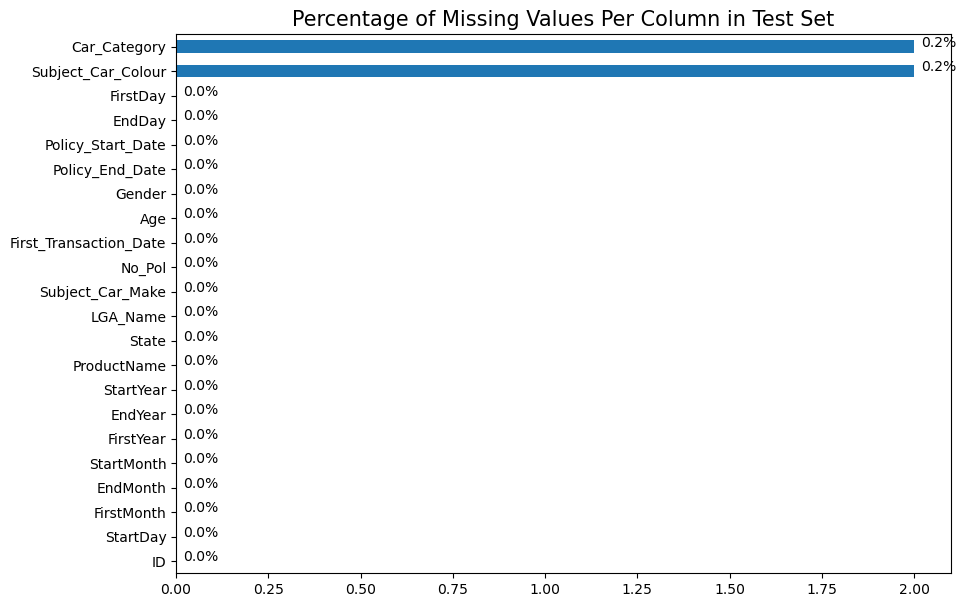

In [265]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [266]:
def clean_age(age):
    if age < 18 and age > 100:
        return np.nan  
    return age

In [267]:
train['Age'] = train['Age'].apply(clean_age)
test['Age'] = test['Age'].apply(clean_age)

age_median = train['Age'].mean()
age_median_t = train['Age'].mean()
train['Age'].fillna(age_median, inplace=True)
test['Age'].fillna(age_median_t, inplace=True)

/var/folders/0n/p9ms0b591cg7_09nh12318dr0000gn/T/ipykernel_37352/4005569889.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(age_median, inplace=True)
/var/folders/0n/p9ms0b591cg7_09nh12318dr0000gn/T/ipykernel_37352/4005569889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

## Feature Engineering

In [268]:
train['Policy_Start_Date'] = pd.to_datetime(train['Policy_Start_Date'])
train['Policy_End_Date'] = pd.to_datetime(train['Policy_End_Date'])
train['First_Transaction_Date'] = pd.to_datetime(train['First_Transaction_Date'])

test['Policy_Start_Date'] = pd.to_datetime(test['Policy_Start_Date'])
test['Policy_End_Date'] = pd.to_datetime(test['Policy_End_Date'])
test['First_Transaction_Date'] = pd.to_datetime(test['First_Transaction_Date'])

In [269]:
train['Policy_Duration'] = (train['Policy_End_Date'] - train['Policy_Start_Date']).dt.days
train['Customer_Tenure'] = (train['Policy_Start_Date'] - train['First_Transaction_Date']).dt.days
test['Policy_Duration'] = (test['Policy_End_Date'] - test['Policy_Start_Date']).dt.days
test['Customer_Tenure'] = (test['Policy_Start_Date'] - test['First_Transaction_Date']).dt.days

today = pd.Timestamp.today()
train['Recency'] = (today - train['Policy_End_Date']).dt.days
test['Recency'] = (today - test['Policy_End_Date']).dt.days

## Encoding Categorical Values

In [270]:

categorical_columns = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = encoder.fit_transform(train[categorical_columns])
encoded_test = encoder.transform(test[categorical_columns])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

train = train.drop(columns=categorical_columns).reset_index(drop=True)
test = test.drop(columns=categorical_columns).reset_index(drop=True)

train = pd.concat([train, encoded_train_df], axis=1)
test = pd.concat([test, encoded_test_df], axis=1)

In [271]:
X = train.drop(columns=['ID', 'target', 'Policy_Start_Date', 'Policy_End_Date', 'First_Transaction_Date'])
y = train['target']
X_test = test.drop(columns=['ID', 'Policy_Start_Date', 'Policy_End_Date', 'First_Transaction_Date'])

In [272]:
scaler = StandardScaler()
numerical_columns = ['Age', 'No_Pol', 'Policy_Duration', 'Customer_Tenure', 'Recency']
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [273]:
model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier()

In [274]:
train_predictions = model.predict(X)

f1 = f1_score(y, train_predictions)
precision = precision_score(y, train_predictions)
recall = recall_score(y, train_predictions)
conf_matrix = confusion_matrix(y, train_predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

F1 Score: 0.8870
Precision: 0.9817
Recall: 0.8089
Confusion Matrix:
[[10602    22]
 [  278  1177]]


In [275]:
# Feature importance
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances

,importance
Age,0.091728
Recency,0.074434
ProductName_CarSafe,0.066498
EndDay,0.041071
StartDay,0.038256
...,...
LGA_Name_Ekiti,0.000000
LGA_Name_Eket,0.000000
LGA_Name_Ekeremor,0.000000
LGA_Name_Ejigbo,0.000000


In [276]:
test_predictions = model.predict(X_test)

In [277]:
test_predictions = model.predict(X_test)
pd.set_option('display.max_rows', 20)

pd.DataFrame(test_predictions).value_counts()

0
0    1102
1     100
Name: count, dtype: int64

In [278]:
sample_submission['target'] = test_predictions
sample_submission.to_csv('submission.csv', index=False)